In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
# import the dataset
movie_reviews = pd.read_csv("/content/drive/MyDrive/Datset_NLP/a1_IMDB_Dataset.csv")

In [ ]:
movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# checking for missing values
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

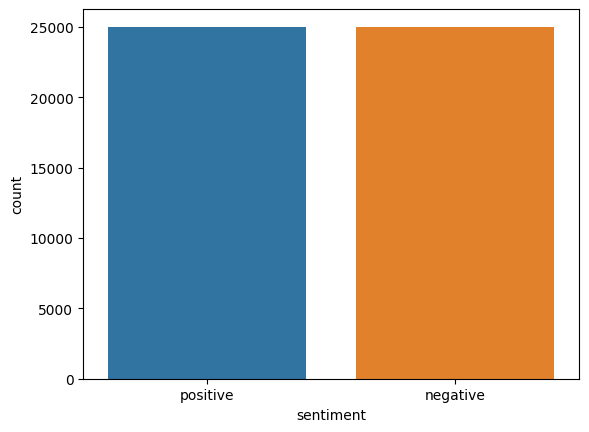

In [ ]:
# check distribution of positive/negative sentiments

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [ ]:
movie_reviews['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
TAG_RE=re.compile(r'<[^>]+>')

def remove_tags(text):
  '''Removes HTML tags, replacing it with blank spaces'''
  return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence    

In [ ]:
X=[]
sentences=list(movie_reviews['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

In [ ]:
# preprocessed text

X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [ ]:
# converting sentiment labels to 0 and 1

y=movie_reviews['sentiment']
y=np.array(list(map(lambda x: 1 if x=='positive' else 0,y)))

In [ ]:
#train-test split

X_train,X_test, y_train, y_test=train_test_split(X,y, test_size=.2, random_state=42)

Embedding Layer

In [ ]:
# Embedding layer converts text data to numeric form

word_tokenizer=Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train=word_tokenizer.texts_to_sequences(X_train)
X_test=word_tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_length= len(word_tokenizer.word_index)+1
vocab_length

92394

In [ ]:
# fix all review sizes to 100

maxlen=100
X_train=pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test=pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Loading GloVe word embeddings and creating Embeddings diactionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary=dict()
glove_file=open('/content/drive/MyDrive/Datset_NLP/a2_glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
  records= line.split()
  word= records[0]
  vector_dimensions= asarray(records[1:], dtype='float32')
  embeddings_dictionary[word]= vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(92394, 100)

Simple Neural Network

In [ ]:
# NN architecture

snn_model=Sequential()
embedding_layer= Embedding(vocab_length, 100, weights= [embedding_matrix], input_length= maxlen, trainable= False)
snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation= 'sigmoid'))

In [ ]:
# Compile Model

snn_model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['acc'])
print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,249,401
Trainable params: 10,001
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [ ]:
snn_model_history= snn_model.fit(X_train, y_train, batch_size=128, epochs= 6, verbose= 1, validation_split= .2)

Epoch 1/6
250/250 [==============================] - 2s 4ms/step - loss: 0.5581 - acc: 0.7135 - val_loss: 0.5037 - val_acc: 0.7581
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4486 - acc: 0.7934 - val_loss: 0.5062 - val_acc: 0.7565
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4118 - acc: 0.8162 - val_loss: 0.5001 - val_acc: 0.7667
Epoch 4/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3893 - acc: 0.8273 - val_loss: 0.5092 - val_acc: 0.7624
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3764 - acc: 0.8355 - val_loss: 0.5188 - val_acc: 0.7626
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3655 - acc: 0.8409 - val_loss: 0.5301 - val_acc: 0.7570


In [ ]:
# prediction on the test set

score= snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5598 - acc: 0.7490


In [ ]:
# Model Performance

print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.5598334670066833
Test Accuracy:  0.7490000128746033


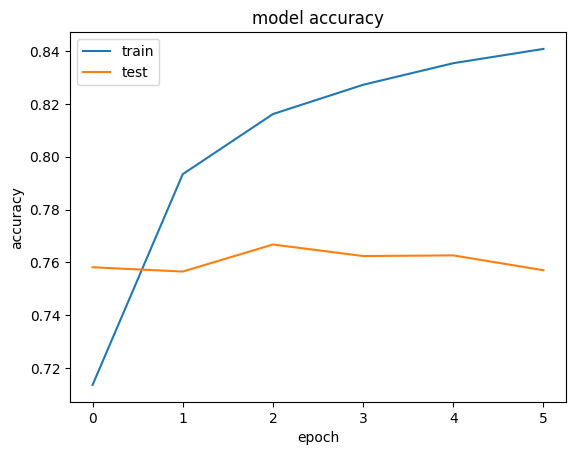

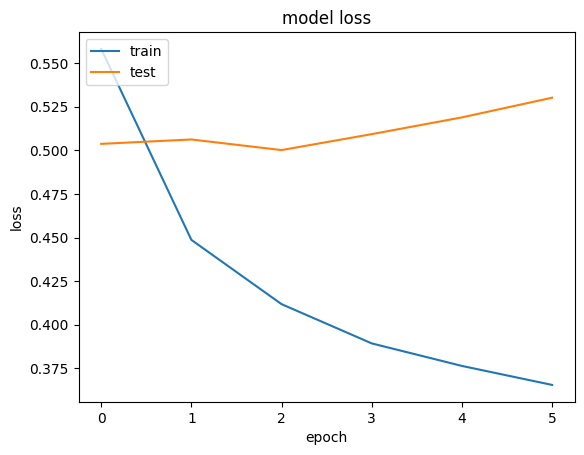

In [ ]:
# Performance chart

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.layers import Conv1D

In [ ]:
# CNN Architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile model

cnn_model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['acc'])
print(cnn_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [ ]:
# Model training

cnn_model_history= cnn_model.fit(X_train, y_train, batch_size= 128, epochs= 6, verbose= 1, validation_split= 0.2)

Epoch 1/6
250/250 [==============================] - 21s 76ms/step - loss: 0.4751 - acc: 0.7704 - val_loss: 0.3784 - val_acc: 0.8315
Epoch 2/6
250/250 [==============================] - 17s 69ms/step - loss: 0.3458 - acc: 0.8510 - val_loss: 0.3554 - val_acc: 0.8409
Epoch 3/6
250/250 [==============================] - 18s 73ms/step - loss: 0.2908 - acc: 0.8824 - val_loss: 0.3452 - val_acc: 0.8456
Epoch 4/6
250/250 [==============================] - 17s 68ms/step - loss: 0.2431 - acc: 0.9090 - val_loss: 0.3380 - val_acc: 0.8470
Epoch 5/6
250/250 [==============================] - 17s 69ms/step - loss: 0.2066 - acc: 0.9288 - val_loss: 0.3315 - val_acc: 0.8575
Epoch 6/6
250/250 [==============================] - 20s 78ms/step - loss: 0.1690 - acc: 0.9487 - val_loss: 0.3406 - val_acc: 0.8529


In [ ]:
# Prediction on the test set

score= cnn_model.evaluate(X_test, y_test, verbose= 1)

313/313 [==============================] - 3s 9ms/step - loss: 0.3421 - acc: 0.8545


In [ ]:
# model performance

print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Test score:  0.3420927822589874
Test accuracy:  0.8544999957084656


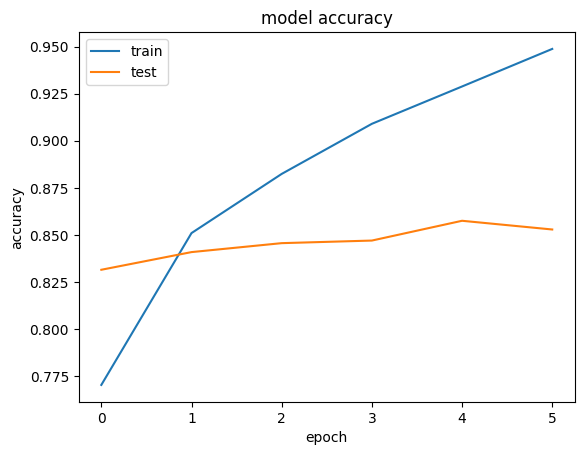

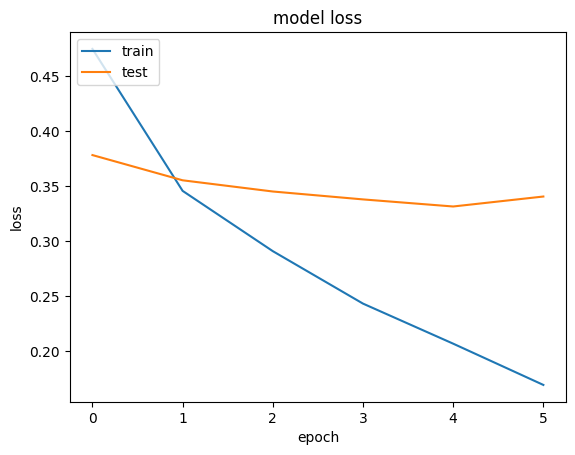

In [ ]:
# Preformance plot

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')
plt.show()

LSTM

In [ ]:
from keras.layers import LSTM

In [ ]:
#LSTM architecture

lstm_model= Sequential()
embedding_layer= Embedding(vocab_length, 100, weights= [embedding_matrix], input_length= maxlen, trainable= False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation= 'sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [ ]:
# Model training

lstm_model_history= lstm_model.fit(X_train, y_train, batch_size= 128, epochs= 6, verbose= 1,validation_split= 0.2)

Epoch 1/6
250/250 [==============================] - 68s 263ms/step - loss: 0.5137 - acc: 0.7522 - val_loss: 0.4329 - val_acc: 0.8037
Epoch 2/6
250/250 [==============================] - 59s 237ms/step - loss: 0.4139 - acc: 0.8156 - val_loss: 0.3821 - val_acc: 0.8334
Epoch 3/6
250/250 [==============================] - 55s 221ms/step - loss: 0.3739 - acc: 0.8376 - val_loss: 0.3541 - val_acc: 0.8495
Epoch 4/6
250/250 [==============================] - 62s 248ms/step - loss: 0.3461 - acc: 0.8546 - val_loss: 0.3364 - val_acc: 0.8593
Epoch 5/6
250/250 [==============================] - 57s 227ms/step - loss: 0.3231 - acc: 0.8638 - val_loss: 0.3273 - val_acc: 0.8614
Epoch 6/6
250/250 [==============================] - 61s 243ms/step - loss: 0.3069 - acc: 0.8727 - val_loss: 0.3152 - val_acc: 0.8680


In [ ]:
# Predictions on the test set

score= lstm_model.evaluate(X_test, y_test, verbose= 1)

313/313 [==============================] - 13s 41ms/step - loss: 0.3195 - acc: 0.8640


In [ ]:
# Model performance

print('Test score: ',score[0])
print('Test accuracy: ',score[1])

Test score:  0.3194798231124878
Test accuracy:  0.8640000224113464


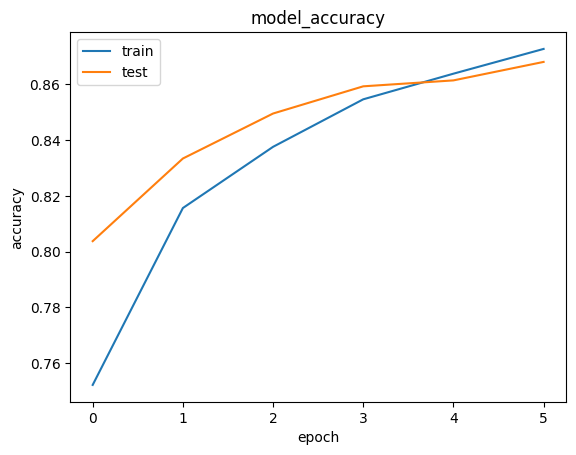

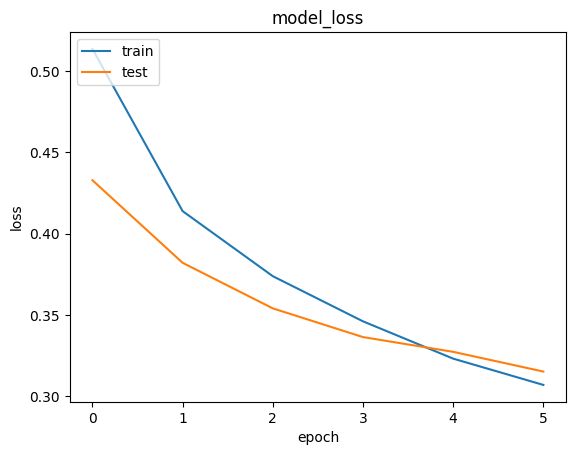

In [ ]:
# Performane plot

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')
plt.show()